In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import sys
from tqdm import tqdm
sys.path.insert(0, os.getcwd() + '/code')
from viz import *
from helper_functions import * 
from multiprocessing import Pool
from scipy.signal import argrelextrema

In [2]:
df_game = pd.read_csv("data/games.csv")
df_tracking = pd.read_csv("data/week1.csv")
df_play = pd.read_csv("data/plays.csv")
df_players = pd.read_csv("data/players.csv")
df_pffScoutingData = pd.read_csv("data/pffScoutingData.csv")

df_tracking = pd.read_csv(f"data/week{1}.csv")
df_area_t = pd.read_csv(f"data/area/area_t.csv").drop(columns=['Unnamed: 0','Unnamed: 0.1'])
df_area_features = pd.read_csv(f"data/area_features/Area_features.csv").drop(columns=['Unnamed: 0'])
#playIds = df_area.playId.unique()

In [3]:
print(df_area_t)

        frameId       Area  playId      gameId
0             1  22.319900      97  2021090900
1             2  22.162750      97  2021090900
2             3  22.160150      97  2021090900
3             4  22.453350      97  2021090900
4             5  22.727850      97  2021090900
...         ...        ...     ...         ...
361365       54   9.889471    4433  2021110100
361366       55  11.820654    4433  2021110100
361367       56  12.093260    4433  2021110100
361368       57  12.366510    4433  2021110100
361369       58   7.808204    4433  2021110100

[361370 rows x 4 columns]


In [4]:
print(df_area_features)

      playId      gameId     event  te         Ae  tc         Ac  tsnap
0         97  2021090900      pass  35  12.237518  25  21.761567      5
1        137  2021090900      pass  26  16.305513  16  26.883350      6
2        187  2021090900      pass  23  18.312900  15  23.691000      5
3        282  2021090900      pass  33  29.901092  22  36.739526      5
4        349  2021090900      pass  27  14.784734  13  20.197600      6
...      ...         ...       ...  ..        ...  ..        ...    ...
7039    4310  2021110100  scramble  34  27.696650  16  28.547650      6
7040    4363  2021110100  scramble  35  12.143444  16  23.476700      6
7041    4392  2021110100      sack  42  13.393264  33  17.607850      6
7042    4411  2021110100      pass  27  12.437731  13  23.665450      6
7043    4433  2021110100  scramble  47   9.259213  33  10.842546      6

[7044 rows x 8 columns]


In [5]:
print(f'Total n° of plays : {len(df_play)}')
scramble_mask = "(event == 'scramble' | event == 'sack')"
scramble_plays = df_area_features.query(scramble_mask)
scramble_plays = pd.merge(scramble_plays,df_play,how="left",on = ["playId","gameId"])
print(f'n° of scramble or sack plays : {len(scramble_plays)}')
scramble_plays_wo_PA = scramble_plays[scramble_plays.pff_playAction == 0]
print(f'n° of scramble or sack plays w/o play action : {len(scramble_plays_wo_PA)}')
print(scramble_plays_wo_PA)


Total n° of plays : 8557
n° of scramble or sack plays : 1683
n° of scramble or sack plays w/o play action : 1127
      playId      gameId     event  te         Ae  tc         Ac  tsnap  \
1        947  2021090900  scramble  32   6.471160  13  21.118500      5   
5       2032  2021090900  scramble  33  13.483074  24  23.139350      5   
6       2279  2021090900  scramble  30   8.196493  12  19.694750      5   
7       2298  2021090900  scramble  36   4.706347  18  24.797850      5   
8       2330  2021090900  scramble  37  23.306400  17  22.632700      5   
...      ...         ...       ...  ..        ...  ..        ...    ...   
1678    4049  2021110100  scramble  24  39.334050   2  31.693500      7   
1679    4310  2021110100  scramble  34  27.696650  16  28.547650      6   
1680    4363  2021110100  scramble  35  12.143444  16  23.476700      6   
1681    4392  2021110100      sack  42  13.393264  33  17.607850      6   
1682    4433  2021110100  scramble  47   9.259213  33  10.8425

In [6]:
scramble_plays["Acrit"] = np.nan
for scramble_id in tqdm(scramble_plays.index):

    scramble_play = scramble_plays.loc[scramble_id].playId
    scramble_game = scramble_plays.loc[scramble_id].gameId

    selected_area_features_df = df_area_features[(df_area_features .playId==scramble_play)&(df_area_features.gameId==scramble_game)].copy()
    selected_area_t_df = df_area_t[(df_area_t.playId==scramble_play)&(df_area_t.gameId==scramble_game)].copy()

    Acrit = np.min(selected_area_t_df[selected_area_t_df.frameId <= int(selected_area_features_df.te)].Area)
    scramble_plays.loc[scramble_id,"Acrit"] = Acrit
print(scramble_plays)
print(scramble_plays.Acrit.mean())
print(scramble_plays.Acrit.std())


100%|██████████| 1683/1683 [00:08<00:00, 204.00it/s]


      playId      gameId     event  te         Ae  tc         Ac  tsnap  \
0        735  2021090900  scramble  35  49.791600   1  35.821550      5   
1        947  2021090900  scramble  32   6.471160  13  21.118500      5   
2       1312  2021090900  scramble  19  28.861884  14  21.430820      5   
3       1425  2021090900  scramble  25  32.751879  19  42.508076      6   
4       1506  2021090900  scramble  39  18.841800  19  23.802860      6   
...      ...         ...       ...  ..        ...  ..        ...    ...   
1678    4049  2021110100  scramble  24  39.334050   2  31.693500      7   
1679    4310  2021110100  scramble  34  27.696650  16  28.547650      6   
1680    4363  2021110100  scramble  35  12.143444  16  23.476700      6   
1681    4392  2021110100      sack  42  13.393264  33  17.607850      6   
1682    4433  2021110100  scramble  47   9.259213  33  10.842546      6   

                                        playDescription  quarter  ...  \
0     (2:45) (Shotgun) D.P

In [7]:
scramble_plays_wo_PA["Acrit"] = np.nan
print(len(scramble_plays_wo_PA))
for scramble_id in tqdm(scramble_plays_wo_PA.index):

    scramble_play = scramble_plays_wo_PA.loc[scramble_id].playId
    scramble_game = scramble_plays_wo_PA.loc[scramble_id].gameId

    selected_area_features_df = df_area_features[(df_area_features .playId==scramble_play)&(df_area_features.gameId==scramble_game)].copy()
    selected_area_t_df = df_area_t[(df_area_t.playId==scramble_play)&(df_area_t.gameId==scramble_game)].copy()

    Acrit = np.min(selected_area_t_df[selected_area_t_df.frameId <= int(selected_area_features_df.te)].Area)
    scramble_plays_wo_PA.loc[scramble_id,"Acrit"] = Acrit
print(scramble_plays_wo_PA)
print(scramble_plays_wo_PA.Acrit.mean())
print(scramble_plays_wo_PA.Acrit.std())

/tmp/ipykernel_11708/2300602930.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1127


100%|██████████| 1127/1127 [00:05<00:00, 189.53it/s]

      playId      gameId     event  te         Ae  tc         Ac  tsnap  \
1        947  2021090900  scramble  32   6.471160  13  21.118500      5   
5       2032  2021090900  scramble  33  13.483074  24  23.139350      5   
6       2279  2021090900  scramble  30   8.196493  12  19.694750      5   
7       2298  2021090900  scramble  36   4.706347  18  24.797850      5   
8       2330  2021090900  scramble  37  23.306400  17  22.632700      5   
...      ...         ...       ...  ..        ...  ..        ...    ...   
1678    4049  2021110100  scramble  24  39.334050   2  31.693500      7   
1679    4310  2021110100  scramble  34  27.696650  16  28.547650      6   
1680    4363  2021110100  scramble  35  12.143444  16  23.476700      6   
1681    4392  2021110100      sack  42  13.393264  33  17.607850      6   
1682    4433  2021110100  scramble  47   9.259213  33  10.842546      6   

                                        playDescription  quarter  ...  \
1     (:05) (Shotgun) T.Br

In [9]:
print(f'Total n° of plays : {len(df_play)}')
pass_mask = "event == 'pass'"
pass_plays = df_area_features.query(pass_mask)
pass_plays = pd.merge(pass_plays,df_play,how="left",on = ["playId","gameId"])
print(f'n° of pass plays : {len(pass_plays)}')
pass_plays_wo_PA = pass_plays[pass_plays.pff_playAction == 0]
print(f'n° of scramble or sack plays w/o play action : {len(pass_plays_wo_PA)}')
print(pass_plays_wo_PA)

Total n° of plays : 8557
n° of pass plays : 5361
n° of scramble or sack plays w/o play action : 4326
      playId      gameId event  te         Ae  tc         Ac  tsnap  \
0         97  2021090900  pass  35  12.237518  25  21.761567      5   
1        137  2021090900  pass  26  16.305513  16  26.883350      6   
2        187  2021090900  pass  23  18.312900  15  23.691000      5   
4        349  2021090900  pass  27  14.784734  13  20.197600      6   
5        410  2021090900  pass  17  15.032565   1  20.318050      5   
...      ...         ...   ...  ..        ...  ..        ...    ...   
5354    3392  2021110100  pass  28  11.988250  14  28.282550      6   
5356    3572  2021110100  pass  33   6.898700  14  29.877850      6   
5358    4071  2021110100  pass  32  15.314200  18  30.096100      6   
5359    4113  2021110100  pass  27  19.062700  15  26.390000      6   
5360    4411  2021110100  pass  27  12.437731  13  23.665450      6   

                                        playDe

In [10]:
print(pass_plays.Ae.mean())
print(pass_plays.Ae.std())

print(pass_plays_wo_PA.Ae.mean())
print(pass_plays_wo_PA.Ae.std())

19.35793970735675
11.729398514231473
16.798856086059942
7.4430277158637965


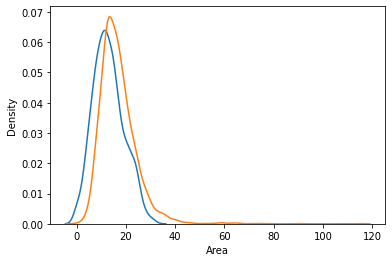

In [17]:
import seaborn as sns
sns.kdeplot(scramble_plays_wo_PA.Acrit)
sns.kdeplot(pass_plays_wo_PA.Ae)
plt.xlabel("Area")
plt.show()

In [23]:
from scipy.stats import normaltest
from scipy.stats import ttest_ind
test = normaltest(scramble_plays_wo_PA.Acrit)
print(f"p-value for normality test Acrit on scramble plays : {test.pvalue}")
test = normaltest(pass_plays_wo_PA.Ae)
print(f"p-value for normality test Ae on pass plays : {test.pvalue}")

test = ttest_ind(scramble_plays_wo_PA.Acrit, pass_plays_wo_PA.Ae)
print(f"Statistic for T-test : {test.statistic}")
print(f"p-value for T-test : {test.pvalue}")

p-value for normality test Acrit on scramble plays : 7.473619333378096e-07
p-value for normality test Ae on pass plays : 0.0
Statistic for T-test : -16.07306857570401
p-value for T-test : 7.841961880885834e-57
